In [86]:
from tqdm import tqdm
import requests
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
# import networkx as nx
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import numpy as np
import plotly.express as px
from textwrap import wrap
import networkx as nx
from tqdm import tqdm
import os
from urllib.parse import urlparse, unquote
import pickle
import re
from networkx.algorithms import bipartite
from datetime import datetime



In [2]:
# url = "https://www.heste-nettet.dk/forum/1/1316128/1316128/"
headers = {"User-Agent": "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/88.0.4324.96 Safari/537.36"} 



def get_html_content(url, save_dir):
    # Parse the URL to get the path
    parsed_url = urlparse(url)
    # Decode any percent-encoded characters in the path
    path = unquote(parsed_url.path)
    
    # Remove the leading and trailing slashes and replace remaining slashes with underscores
    filename = path.strip('/').replace('/', '_') + '.html'
    
    # Check if the directory exists, if not, create it
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    # Define the path for the file
    file_path = os.path.join(save_dir, filename)

    # Check if the file already exists
    if not os.path.isfile(file_path):
        # If not, make a request and save the file
        response = requests.get(url, headers=headers)
        if response.status_code == 200:
            with open(file_path, 'w', encoding='utf-8') as file:
                file.write(response.text)
            soup = BeautifulSoup(response.text, "html.parser")
            return soup
        elif response.status_code in [404, 403]:
            print(f"Response code: {response.status_code} for {url}")
        else:
            return None
    else:
        # If the file exists, read it from the disk
        with open(file_path, 'r', encoding='utf-8') as file:
            content = file.read()
        soup = BeautifulSoup(content, "html.parser")
        return soup



In [143]:
from glob import glob

In [146]:
files = glob('html_scrape/*')

In [155]:
posts = [post for post in files if len(post.split('_'))==5]

In [159]:
indexs = [index for index in files if len(index.split('_'))==4]

In [3]:

def author_text_scrape(soup):
    author_list = []
    text_list = []
    # Find all the <td> elements with class "light" and itemprop="text"
    td_elements = soup.find_all('td', bgcolor='#787878', valign='top')

    # Iterate through the <td> elements
    for td in td_elements:
        # Extract the author's href number
        author_a = td.find('a', itemprop='url')
        if author_a:
            author_href = author_a['href']
            author_text = author_a.text
            
        else:
            author_href = None
            author_text = td.find('span', itemprop='name').text
        # print(author_text)
        # Find the first <div> with class "rsPost" within the current <td>
        rs_post = td.find('div', class_='rsPost')
        
        if rs_post:
            # Extract Danish text within <span> tags
            danish_text = [span.text for span in rs_post.find_all('p')]
            
            # Combine the text into a single string
            danish_text = "\n".join(danish_text)
                
            # if len(danish_text)>1 and author_text:
                # author_list.append(author_href.split('/')[-2])
            author_list.append(author_text)
            text_list.append(danish_text)
        # if author_text == "Doctor Who" and len(author_list)<2:
        #     print(rs_post)

    return author_list, text_list


In [5]:
# page_links = []
# def get_new_page_link(result):
#     page_links.append(result)
#     soup = get_html_content(f"https://www.heste-nettet.dk{result}")
#     result = soup.find('a', string = 'Ældre indlæg')['href']
#     if result:
#         print(result)
#         get_new_page_link(result)
#     else:
#         return False
# get_new_page_link('/forum/1/')

In [111]:
date_format = "%d-%m-%y %H:%M"
def extract_timestamp_and_tag_of_post(soup):
    rows = soup.find_all('tr', {'valign': 'middle'})

    for row in rows:
        # Find all <td> elements with class 'light' within each row
        light_tds = row.find_all('td', class_='light')
        b_element = light_tds[1].find('span').find('b')
        tag = b_element.text
        # Select the last <td> element if it exists
        if light_tds:
            last_light_td = light_tds[-1]
            # Do something with last_light_td, e.g., print it
            return datetime.strptime(last_light_td.text,date_format),tag

In [196]:
html_dir = './html_scrape'
href_list = []
post_title_list = []
timestamp_list = []
post_tag_list = []
amount_of_post = int(10500/2+1) #int(210+1) 

time_cutoff = datetime.strptime("01-01-20 00:00", "%d-%m-%y %H:%M")

for page_index in tqdm(range(70,amount_of_post,70)): # 185780
    soup = get_html_content(f"https://www.heste-nettet.dk/forum/1/{page_index}/",html_dir)
    post_links = soup.find_all("a",href=True)
    timestamp,post_tag = extract_timestamp_and_tag_of_post(soup)
    # if timestamp<time_cutoff:
    #     print(timestamp)
    #     break
    # Filter and print the links
    for link in post_links:
        href = link['href']
        if "/forum/1/" in href and len(href.split("/"))==6:
            href_list.append(href)
            post_title_list.append(link.text)
            timestamp_list.append(timestamp)
            post_tag_list.append(post_tag)

100%|██████████| 75/75 [00:02<00:00, 32.69it/s]


In [197]:
authors_data = []
texts_data = []
used_href_list = []
used_titles_list = []
used_timestamps_list = []
used_tag_list = []
for idx,href in enumerate(tqdm(href_list)):
    url = f"https://www.heste-nettet.dk{href}"
    if (soup:=get_html_content(url,html_dir)):
        author_list, text_list = author_text_scrape(soup)
        if len(author_list)>0 and len(text_list)>0:
            authors_data.append(author_list)
            texts_data.append(text_list)
            used_href_list.append(href)
            used_titles_list.append(post_title_list[idx])
            used_timestamps_list.append(timestamp_list[idx])
            used_tag_list.append(post_tag_list[idx])

100%|██████████| 5250/5250 [02:07<00:00, 41.22it/s]


In [183]:
len(used_href_list)

210

In [198]:
def clean_and_concatenate(data):
    # Remove empty strings
    data = [s for s in data if s.strip()]

    # Normalize whitespace and replace non-breaking spaces
    cleaned_data = [re.sub(r'\s+', ' ', s.replace('\xa0', ' ')).strip() for s in data]

    # Concatenate the strings into a single text
    concatenated_text = ' '.join(cleaned_data)
    return concatenated_text


In [199]:
# Initialize a directed graph (DiGraph)
G = nx.Graph()

# Initialize a dictionary to store text lengths for each author
author_text_lengths = {}

# Keep track of added nodes
added_nodes = set()

# Process each webpage
for idx, (authors, text_sections) in enumerate(zip(authors_data, texts_data)):

    # Extract corresponding data
    post_node = used_href_list[idx]
    title_of_post = used_titles_list[idx]
    post_text = clean_and_concatenate(texts_data[idx])
    post_timestamp = used_timestamps_list[idx]
    post_tag = used_tag_list[idx]
    # Create nodes
    G.add_nodes_from(authors,bipartite=0,OP_author=0)
    G.add_node(post_node,bipartite=1,title=title_of_post,text=post_text,timestamp = post_timestamp,tag=post_tag)

    # Create edges:
    for author in authors:
        G.add_edge(author,post_node)

    #Track how many times a person has made a post
    op_author = authors[0]
    G.nodes[op_author]["OP_author"] += 1


In [200]:
C_G = nx.connected_components(G)
graph_list = [(len(graph),graph) for graph in C_G]
all_lens = [length for (length,nodes) in graph_list]
max_idx = np.argmax(all_lens)
size_larg, largest_subgraph = graph_list[max_idx]
G_connected = G.subgraph(largest_subgraph).copy()

with open(f'Bipartite_G_{amount_of_post}_cutoff_v2.pkl', 'wb') as f:
    pickle.dump(G_connected, f)

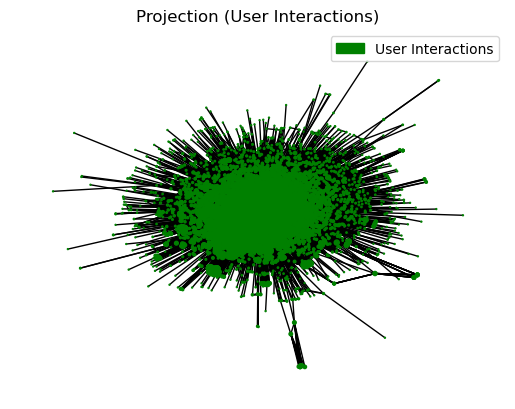

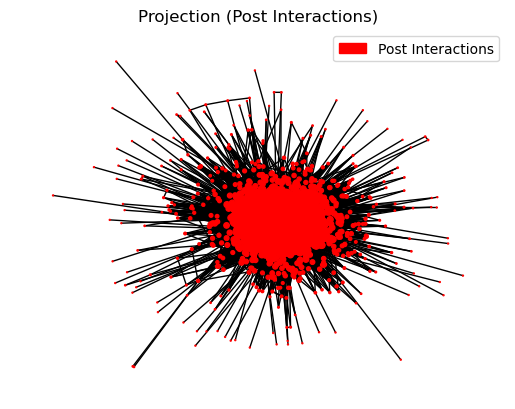

In [201]:
import networkx as nx
from networkx.algorithms import bipartite
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Assuming G_connected is defined and is a bipartite graph
U, V = bipartite.sets(G_connected)
U_projected = bipartite.projected_graph(G_connected, U)
V_projected = bipartite.projected_graph(G_connected, V)

# Calculate degrees for U_projected and V_projected
U_degrees = [U_projected.degree(n) for n in U_projected]
V_degrees = [V_projected.degree(n) for n in V_projected]

# Scale factor for node sizes
scale_factor = 0.5

# Drawing U_projected
plt.figure()
plt.title("Projection (User Interactions)")
nx.draw(U_projected, 
        node_color='green', 
        node_size=[d * scale_factor for d in U_degrees], 
        with_labels=False)

# Create a legend for U_projected
green_patch = mpatches.Patch(color='green', label='User Interactions')
plt.legend(handles=[green_patch])

# Drawing V_projected
plt.figure()
plt.title("Projection (Post Interactions)")
nx.draw(V_projected, 
        node_color='red', 
        node_size=[d * scale_factor for d in V_degrees], 
        with_labels=False)

# Create a legend for V_projected
red_patch = mpatches.Patch(color='red', label='Post Interactions')
plt.legend(handles=[red_patch])

plt.show()


In [202]:
len(U_projected.nodes)

5576

In [203]:
len(V_projected.nodes)

4984

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


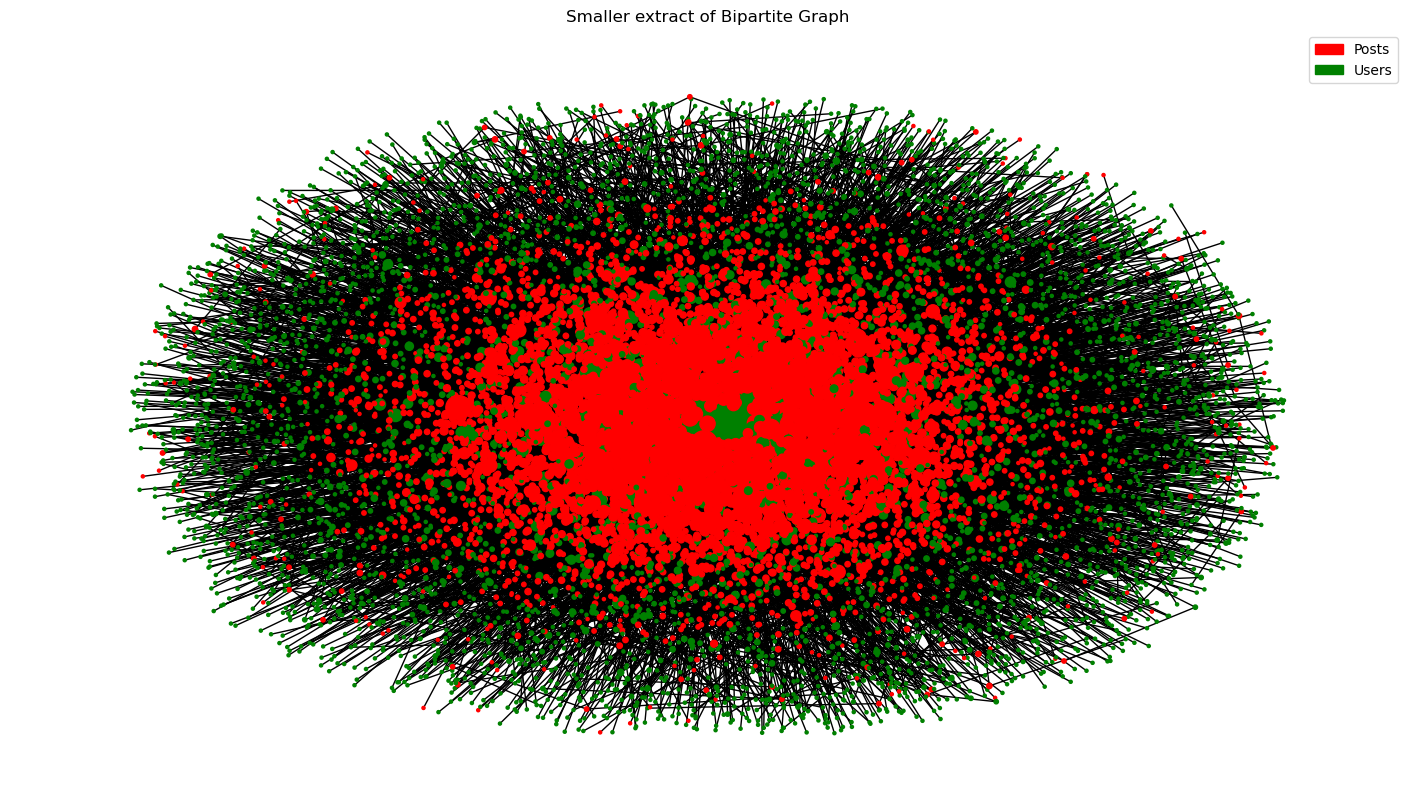

In [206]:
plt.figure(figsize=(18, 10))
node_sizes = [G_connected.degree(node) * 5  for node in G_connected.nodes()]

# Assign colors: green for users (U), red for posts (V)
node_colors = ['green' if node in U else 'red' for node in G_connected.nodes()]
pos = nx.spring_layout(G_connected, k=0.1)
# Draw the graph
plt.title("Smaller extract of Bipartite Graph")
nx.draw(G_connected,pos=pos, node_size=node_sizes, node_color=node_colors, with_labels=False)
plt.legend()
red_patch = mpatches.Patch(color='red', label='Posts')
green_patch = mpatches.Patch(color='green', label='Users')
plt.legend(handles=[red_patch,green_patch])
plt.show()

In [166]:
from operator import itemgetter

bipartite_1_nodes_with_datetime = [(node, data.get('timestamp'))
                                   for node, data in G.nodes(data=True)
                                   if data.get('bipartite') == 1]

# Sort the nodes based on the datetime attribute
sorted_nodes = sorted(bipartite_1_nodes_with_datetime, key=itemgetter(1),reverse=False)
sorted_nodes

[('/forum/1/2389064/2389064/', datetime.datetime(2014, 5, 15, 22, 35)),
 ('/forum/1/2388942/2388942/', datetime.datetime(2014, 5, 15, 22, 35)),
 ('/forum/1/2389002/2389002/', datetime.datetime(2014, 5, 15, 22, 35)),
 ('/forum/1/2389013/2389013/', datetime.datetime(2014, 5, 15, 22, 35)),
 ('/forum/1/2389060/2389060/', datetime.datetime(2014, 5, 15, 22, 35)),
 ('/forum/1/2387453/2387453/', datetime.datetime(2014, 5, 15, 22, 35)),
 ('/forum/1/2388969/2388969/', datetime.datetime(2014, 5, 15, 22, 35)),
 ('/forum/1/2388937/2388937/', datetime.datetime(2014, 5, 15, 22, 35)),
 ('/forum/1/2388962/2388962/', datetime.datetime(2014, 5, 15, 22, 35)),
 ('/forum/1/2388832/2388832/', datetime.datetime(2014, 5, 15, 22, 35)),
 ('/forum/1/2388822/2388822/', datetime.datetime(2014, 5, 15, 22, 35)),
 ('/forum/1/2388996/2388996/', datetime.datetime(2014, 5, 15, 22, 35)),
 ('/forum/1/2388627/2388627/', datetime.datetime(2014, 5, 15, 22, 35)),
 ('/forum/1/2388842/2388842/', datetime.datetime(2014, 5, 15, 22

In [133]:
len(G_connected.nodes)

10560

In [131]:
sorted(list(dict(G_connected.degree).items()),key=lambda x:x[1],reverse=True)[:10]

[('Paradise »Lost«', 840),
 ('Shagya', 758),
 ('Charlotte (Stutteri Lund)', 464),
 ('Doctor Who', 385),
 ('Sif', 363),
 ('Sine (Aslan)', 325),
 ('Lady Pernille af Glencoe', 311),
 ('anja n ♥detvarkattens♥', 308),
 ('£isbeth (Baloo)', 281),
 ('6 tegn', 271)]

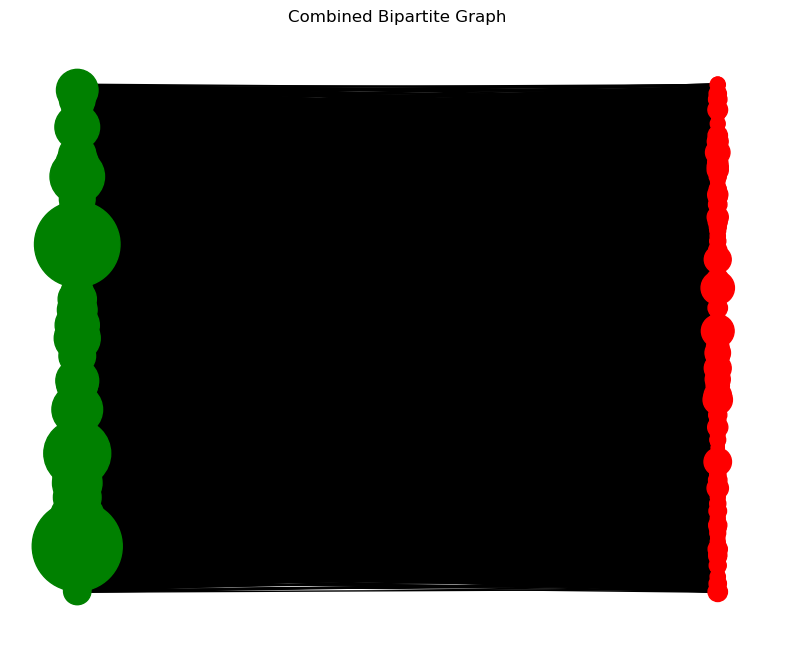

In [132]:
# Assuming G_connected is your connected bipartite graph

# Calculate node sizes based on degree
# You might want to scale these values or set a min/max size
node_sizes = [G_connected.degree(node) * 5 for node in G_connected.nodes()]

# Assign colors: green for users (U), red for posts (V)
node_colors = ['green' if node in U else 'red' for node in G_connected.nodes()]
pos = nx.bipartite_layout(G_connected, U)

# Draw the graph
plt.figure(figsize=(10, 8))
plt.title("Combined Bipartite Graph")
nx.draw(G_connected,pos=pos, node_size=node_sizes, node_color=node_colors, with_labels=False)

plt.show()

# OLD


In [32]:
# Initialize a directed graph (DiGraph)
G = nx.Graph()

# Initialize a dictionary to store text lengths for each author
author_text_lengths = {}

# Keep track of added nodes
added_nodes = set()

# Process each webpage
for idx, (authors, text_sections) in enumerate(zip(authors_data, texts_data)):
    # The first author in the inner list is the OP author
    try:
        op_author = authors[0]
    except:
        print(idx, authors, text_sections)
        break
    
    # Add nodes for all authors, including the OP, and initialize the "OP_author" attribute to 0
    for author in authors:
        if author not in added_nodes:
            G.add_node(author, OP_author=0, reads=0,comments = 0,bipartite=0)
            added_nodes.add(author)

    # Update the "OP_author" attribute for the OP author
    G.nodes[op_author]["OP_author"] += 1
    G.nodes[op_author]["reads"] += len(authors)-1

    # Connect the OP author to all other authors with weighted edges
    for author in authors[1:]:
        if G.has_edge(author, op_author):
            G[author][op_author]["weight"] += 1  # Increment the edge weight
        else:
            G.add_edge(author, op_author, weight=1)  # Initialize edge weight to 1
        
        G.nodes[author]["comments"] += 1

    # Calculate text lengths and store in the author_text_lengths dictionary
    for author, text_section in zip(authors, text_sections):
        text_length = len(text_section)
        author_text_lengths[author] = text_length


In [ ]:
# Pickle the graph
with open(f'Bipartite_G_{amount_of_post}_cutoff_v1.pkl', 'wb') as f:
    pickle.dump(G, f)

# # Later on, to load the graph
# with open('my_graph.pkl', 'rb') as f:
#     G_loaded = pickle.load(f)

In [26]:
def sanitize_string(s):
    return ''.join(char for char in s if char.isprintable())

# Sanitize node and edge attributes
for node, data in G.nodes(data=True):
    for key, value in data.items():
        if isinstance(value, str):
            data[key] = sanitize_string(value)

for u, v, data in G.edges(data=True):
    for key, value in data.items():
        if isinstance(value, str):
            data[key] = sanitize_string(value)

# Now try exporting the graph
nx.write_graphml(G, "sanitized_graph.graphml")

ValueError: All strings must be XML compatible: Unicode or ASCII, no NULL bytes or control characters

In [13]:
nx.write_graphml(G,'medium_graph.graphml')

ValueError: All strings must be XML compatible: Unicode or ASCII, no NULL bytes or control characters

In [ ]:
# edge_weights = {(u, v): G[u][v]['weight'] for u, v in G.edges()}
# for (u, v), weight in edge_weights.items():
#     print(f"Weight of edge between node {u} and node {v}: {weight}")

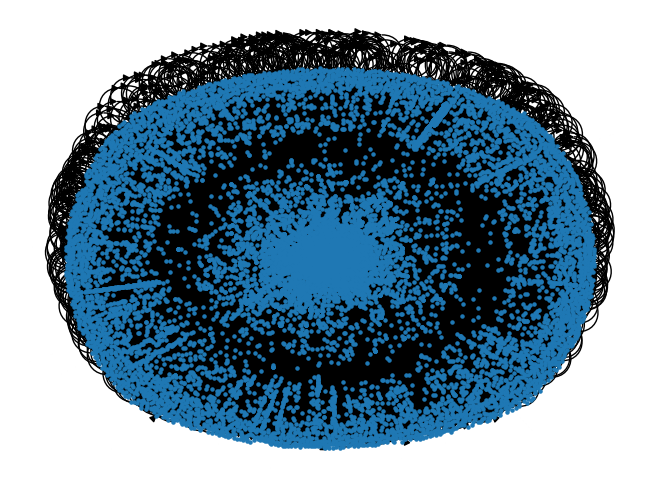

In [35]:
nx.draw(G,node_size=5)


In [ ]:
# sorted(list(dict(G.in_degree).items()),key=lambda x: x[1],reverse=True)
# sorted(list(dict(G.out_degree).items()),key=lambda x: x[1],reverse=True)

In [ ]:
# from pyvis.network import Network

# pyvis_graph = Network(notebook=True,cdn_resources='in_line')
# pyvis_graph.from_nx(G)
# pyvis_graph.show("graph.html")

In [36]:
# Collect edge weights into a list
edge_weights = [G.edges[edge]['weight'] for edge in G.edges()]

# Normalize edge_weights
max_weight = max(edge_weights)
min_weight = min(edge_weights)
edge_weights_normalized = [(w - min_weight)/(max_weight - min_weight) for w in edge_weights]

# Initialize edge colors
edge_colors = []

for weight in edge_weights_normalized:
    edge_colors.extend([f'rgba(0,0,255,{weight})', f'rgba(0,0,255,{weight})', 'rgba(0,0,0,0)'])


In [ ]:
# Layout
pos = nx.spring_layout(G)

# Collect edge weights into a list and normalize them
edge_weights = [G.edges[edge]['weight'] for edge in G.edges()]
max_weight = max(edge_weights)
min_weight = min(edge_weights)

# Initialize list to store edge traces
edge_traces = []

# Loop through each edge to create an edge trace
for edge in G.edges():
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    
    # Get edge weight and normalize it
    weight = G.edges[edge]['weight']
    normalized_weight = (weight - min_weight) / (max_weight - min_weight)
    
    edge_color = f'rgba(0,0,255,{normalized_weight+0.1})'
    
    edge_trace = go.Scatter(
        x=[x0, x1, None],
        y=[y0, y1, None],
        line=dict(width=0.5, color=edge_color),
        hoverinfo='none',
        mode='lines'
    )
    
    edge_traces.append(edge_trace)

# Nodes
node_x = []
node_y = []
node_text = []

node_reads = [G.nodes[node].get('reads', 0) for node in G.nodes()]
max_reads = max(node_reads)
min_reads = min(node_reads)
node_sizes = [(reads - min_reads)/(max_reads - min_reads) * 20 + 10 for reads in node_reads]


for node in G.nodes():
    x, y = pos[node]
    node_x.append(x)
    node_y.append(y)
    # Sample node attributes (Replace this line with your actual node attributes)
    node_text.append(f'Node {node}<br>OP:{G.nodes[node]["OP_author"]}<br>Reads:{G.nodes[node]["reads"]}<br>Comments:{G.nodes[node]["comments"]}')

node_trace = go.Scatter(
    x=node_x,
    y=node_y,
    mode='markers',
    text=node_text,
    textposition="bottom center",
    hoverinfo='text',
    marker=dict(
        showscale=True,
        colorscale='YlGnBu',
        size=node_sizes,  # Node sizes based on 'reads'
        colorbar=dict(
            thickness=15,
            title='Node Color Scale',
            xanchor='left',
            titleside='right'
        )
    )
)

# Create the final figure
fig = go.Figure(data=edge_traces + [node_trace],
                layout=go.Layout(
                    showlegend=False,
                    hovermode='closest',
                    margin=dict(b=0, l=0, r=0, t=0),
                    xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                    yaxis=dict(showgrid=False, zeroline=False, showticklabels=False))
                )

fig.update_layout(
    height=800,
    width=1200
)

fig.show()

In [12]:
fig.write_html("graph_export_medium.html")

NameError: name 'fig' is not defined

In [14]:
import pandas as pd
# Step 1: Extract node attributes
node_list_with_comments = [(node, data['comments']) for node, data in G.nodes(data=True) if 'comments' in data]

# Step 2: Sort the list by 'comment' attribute
sorted_node_list = sorted(node_list_with_comments, key=lambda x: x[1], reverse=True)

# Step 3: Get the top 10 nodes
top_10_nodes = sorted_node_list[:10]

# Step 4: Create a Pandas DataFrame
df = pd.DataFrame(top_10_nodes, columns=['Node_ID', 'Comment_Count'])

df

,Node_ID,Comment_Count
0,£isbeth (Baloo),5200
1,Sandra ♥Cashew♥,2683
2,Stute,2446
3,123456,2430
4,Paradise »Lost«,2405
5,overskrift,2295
6,Shagya,2244
7,Golda Showers,1957
8,Sif,1917
9,Sophie »Whisper«,1895


In [68]:
import pandas as pd
# Step 1: Extract node attributes
node_list_with_comments = [(node, data['OP_author']) for node, data in G.nodes(data=True) if 'OP_author' in data]

# Step 2: Sort the list by 'comment' attribute
sorted_node_list = sorted(node_list_with_comments, key=lambda x: x[1], reverse=True)

# Step 3: Get the top 10 nodes
top_10_nodes = sorted_node_list[:10]

# Step 4: Create a Pandas DataFrame
df = pd.DataFrame(top_10_nodes, columns=['Node_ID', 'Comment_Count'])

df

,Node_ID,Comment_Count
0,inger christensen,1287
1,Vicky02,911
2,Sandra ♥Cashew♥,544
3,Shagya,436
4,Rollo,421
5,Adian,390
6,camilse,373
7,Christina S,348
8,camilse og Looksen,342
9,Iben ♣Sille-Musen♣,338


In [15]:
sorted(list(dict(G.in_degree).items()),key=lambda x:x[1],reverse=True)[:10]

[('Sandra ♥Cashew♥', 1257),
 ('Shagya', 1252),
 ('Adian', 1199),
 ('Janni (Fleur)', 951),
 ('mik27 ☻Mieke☻', 839),
 ('Mor til ♥Emma♥', 805),
 ('klokkeblomst8 ♥Rose♥', 799),
 ('Tina-Tossen', 717),
 ('Iben ♣Sille-Musen♣', 696),
 ('Gold and Dangerous *Dixie*', 691)]

In [16]:
sorted(list(dict(G.out_degree).items()),key=lambda x:x[1],reverse=True)[:10]

[('£isbeth (Baloo)', 1847),
 ('123456', 1214),
 ('overskrift', 1067),
 ('Sif', 1035),
 ('Sandra ♥Cashew♥', 944),
 ('Adian', 922),
 ('Lenuccia', 836),
 ('Shagya', 808),
 ('Stute', 789),
 ('Sophie »Whisper«', 783)]

In [17]:
G_unD = G.to_undirected()

In [18]:
top_ten = sorted(list(dict(G_unD.degree).items()),key=lambda x:x[1],reverse=True)[:10]



In [19]:
df = pd.DataFrame(top_ten,columns=['user','degree'])
df 

,user,degree
0,£isbeth (Baloo),1923
1,Sandra ♥Cashew♥,1865
2,Adian,1827
3,Shagya,1775
4,tije *Fylkir*,1251
5,123456,1214
6,Sif,1182
7,klokkeblomst8 ♥Rose♥,1166
8,Praxis,1150
9,Janni (Fleur),1129


In [20]:
df['comments'] = df['user'].map(lambda x: G.nodes[x]['comments'])


In [21]:
df

,user,degree,comments
0,£isbeth (Baloo),1923,5200
1,Sandra ♥Cashew♥,1865,2683
2,Adian,1827,1818
3,Shagya,1775,2244
4,tije *Fylkir*,1251,1571
5,123456,1214,2430
6,Sif,1182,1917
7,klokkeblomst8 ♥Rose♥,1166,1597
8,Praxis,1150,1356
9,Janni (Fleur),1129,1048


In [22]:
len(G.nodes())

41368

In [23]:
len(G_unD.edges)

223601